<a href="https://colab.research.google.com/github/KelvinM9187/Image-Segmentation-using-UNET/blob/main/UnetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
# Paths to folders
base_path = '/content/drive/My Drive/segmentation_dataset/'
images_path = os.path.join(base_path, 'images/')
masks_path = os.path.join(base_path, 'masks/')

IMG_SIZE = 224  # Resize dimensions

def load_data(images_path, masks_path):
    images = []
    masks = []

    # Load images
    for img_name in sorted(os.listdir(images_path)):
        img = load_img(os.path.join(images_path, img_name), target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)

    # Load masks
    for mask_name in sorted(os.listdir(masks_path)):
        mask = load_img(os.path.join(masks_path, mask_name), target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the data
images, masks = load_data(images_path, masks_path)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [6]:
def unet_model(output_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Downsampling path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upsampling path
    up1 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    concat1 = tf.keras.layers.Concatenate()([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    concat2 = tf.keras.layers.Concatenate()([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='sigmoid')(conv5)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Instantiate the model
model = unet_model(output_channels=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 112, 112, 128)  │        131,200 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 112, 112, 256)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 112, 112, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 224, 224, 64)   │         32,832 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 224, 224, 128)  │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 224, 224, 64)   │         73,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=8,
    epochs=20
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 561ms/step - accuracy: 0.9454 - loss: 0.3160 - val_accuracy: 0.9485 - val_loss: 0.1117
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 230ms/step - accuracy: 0.9563 - loss: 0.1097 - val_accuracy: 0.9580 - val_loss: 0.0776
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.9641 - loss: 0.0719 - val_accuracy: 0.9664 - val_loss: 0.0576
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.9692 - loss: 0.0546 - val_accuracy: 0.9744 - val_loss: 0.0267
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 234ms/step - accuracy: 0.9768 - loss: 0.0274 - val_accuracy: 0.9768 - val_loss: 0.0177
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9830 - loss: 0.0151 - val_accuracy: 0.9776 - val_loss: 0.0148
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.9832 - loss: 0.0132 - val_accuracy: 0.9757 - val_loss: 0.0209
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - accuracy: 0.9824 - loss: 0.0152 - val_accu

In [8]:
# Evaluate on the test set
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9808 - loss: 0.0109
Test Loss: 0.010995082557201385, Test Accuracy: 0.9802033305168152


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step


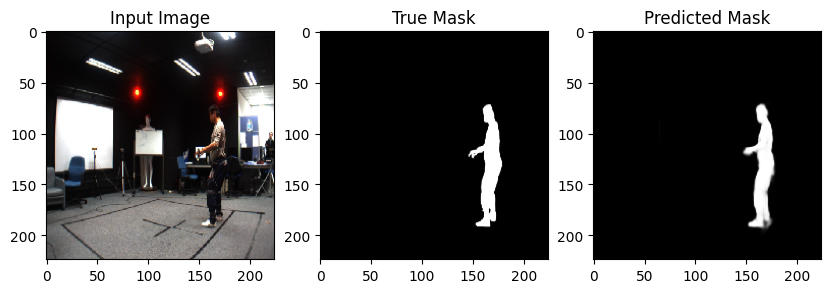

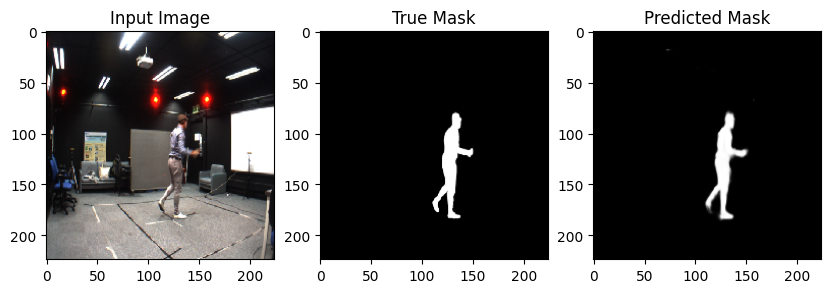

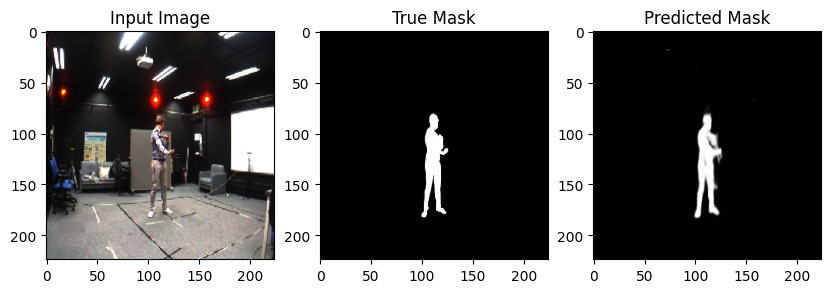

In [9]:
# Predict on test data
predictions = model.predict(X_test)

# Visualize a few results
def display_sample(X, y_true, y_pred, index):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X[index])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_true[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[index].squeeze(), cmap='gray')
    plt.show()

# Display 3 samples
for i in range(3):
    display_sample(X_test, y_test, predictions, i)
